In [16]:
import cupy as cp
import cupyx
import scanpy as sc
import scanpy as sc
import numpy as np
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import random
import pandas as pd
import voyagerpy as vp
import geopandas as gpd
import libpysal as lps
from collections import OrderedDict
import scipy.sparse as sp
import pickle

In [80]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Human_Colon_Cancer_binned_outputs/binned_outputs/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_2"
andata = sc.read_h5ad(os.path.join(pathout, "andata_save_colon.h5ad"))
andata.uns['config'] = OrderedDict()
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
def load_matrix(andata,pathout,npz_file = "obsp_distances.npz",mode = 'sparse', mat_name = 'distances'):
    npzfile = cp.load(os.path.join(pathout, npz_file))
    data = cp.array(npzfile['data'])
    indices = cp.array(npzfile['indices'])
    indptr = cp.array(npzfile['indptr'])
    shape = tuple(npzfile['shape'])
    
    # Reconstruct the sparse matrix
    sparse_matrix_distances = csr_matrix((data, indices, indptr), shape=shape)
    if mode== 'sparse':
        andata.obsp[mat_name] = sparse_matrix_distances
    else:
        andata.obsp[mat_name] = sparse_matrix_distances.get()
    return andata
andata = load_matrix(andata,pathout,npz_file = "obsp_distances_large_colon.npz",mode = 'cupyx', mat_name = 'distances')
andata = load_matrix(andata,pathout,npz_file = "obsp_connectivities_large_colon.npz",mode = 'cupyx', mat_name = 'connectivities')
andata

AnnData object with n_obs × n_vars = 133282 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'config'
    obsm: 'X_pca', 'spatial'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities'

In [81]:
with open(os.path.join(pathout,"andata_uns_mtracies__colon.pkl"), 'rb') as buff:
    andata_uns_mtracies__colon = pickle.load(buff)
andata.uns['rank_genes_groups'] = andata_uns_mtracies__colon['rank_genes_groups']
del andata_uns_mtracies__colon
with open(os.path.join(pathout,"stlearn_uns_mtracies_colon.pkl"), 'rb') as buff:
    stlearn_uns_mtracies_colon = pickle.load(buff)
andata.uns['lrfeatures'] = stlearn_uns_mtracies_colon['lrfeatures']
andata.uns['lr_summary'] = stlearn_uns_mtracies_colon['lr_summary']
del stlearn_uns_mtracies_colon
with open(os.path.join(pathout,"stlearn_obsm_mtracies_colon.pkl"), 'rb') as buff:
    stlearn_obsm_mtracies_colon = pickle.load(buff)
andata.obsm['spot_neighbours'] = stlearn_obsm_mtracies_colon['spot_neighbours']
andata.obsm['spot_neigh_bcs'] = stlearn_obsm_mtracies_colon['spot_neigh_bcs']
andata.obsm['lr_scores'] = stlearn_obsm_mtracies_colon['lr_scores']
andata.obsm['p_vals'] = stlearn_obsm_mtracies_colon['spot_neigh_bcs']
andata.obsm['-log10(p_adjs)'] = stlearn_obsm_mtracies_colon['-log10(p_adjs)']
andata.obsm['lr_sig_scores'] = stlearn_obsm_mtracies_colon['lr_sig_scores']
del stlearn_obsm_mtracies_colon

In [82]:
from scipy.sparse import csr_matrix
andata_sub = andata.copy()
andata_sub.X = csr_matrix(andata_sub.X)
andata_sub = sc.pp.subsample(andata_sub, n_obs=80_000,copy=True)

In [83]:
from cupyx.scipy.sparse import csr_matrix
andata_sub.obsp['distances'] = csr_matrix(andata_sub.obsp['distances'])
andata_sub.obsp['distances'] = csr_matrix(andata_sub.obsp['connectivities'])

In [84]:
import scipy.sparse as sp
sparse_dist_matrix = andata_sub.obsp['distances'].tocsr()
sparse_inv_matrix = sparse_dist_matrix.copy()
sparse_inv_matrix.data = 1 / sparse_inv_matrix.data
sparse_inv_matrix.data[sparse_inv_matrix.data == float('inf')] = 0

In [85]:
# Convert the sparse matrix to COOrdinate format
sparse_inv_matrix_coo = sparse_inv_matrix.tocoo()

# Extract the row (focal) and column (neighbor) indices of non-zero entries
focal = sparse_inv_matrix_coo.row
neighbors = sparse_inv_matrix_coo.col

focal = focal.get()
neighbors = neighbors.get() 

idx = np.array(andata_sub.obs_names,dtype=str) # Assuming this is a pandas Index or a list-like structure

# Convert sparse matrix values to a 1D array explicitly
weights = sparse_inv_matrix_coo.data
weights = weights.get()


# Create a DataFrame with focal, neighbor, and weight information
graph_df = pd.DataFrame({
    "focal": idx[focal],
    "neighbor": idx[neighbors],
    "weight": weights  # The actual non-zero values (inverted distances)
})

# Display the DataFrame to check
graph_df.head()

graph_df_filtered = graph_df[graph_df['weight'] != 0]

remove disconnected nodes (nodes with no nighbars)

In [86]:
neighbor_counts = graph_df.groupby("focal")["neighbor"].count()
# Identify connected nodes (nodes with at least 2 neighbor)
connected_nodes = neighbor_counts[neighbor_counts > 3].index
# Filter graph_df to keep only connected nodes
graph_df_filtered = graph_df_filtered[graph_df_filtered['focal'].isin(connected_nodes)]


In [87]:
W = lps.weights.W.from_adjlist(graph_df_filtered)
W.set_transform("r")

In [88]:
knn_graph = "knn_weights"
andata_sub.obsp["knn_weights"] = sparse_inv_matrix.get()

andata_sub.uns.setdefault("spatial", {})
andata_sub.uns["spatial"][knn_graph] = W

In [89]:
qc_features = ["total_counts"]
morans = vp.spatial.moran(andata_sub, qc_features, graph_name=knn_graph)
andata_sub.uns['spatial']['moran'][knn_graph].loc[qc_features, ["I"]]

,I
total_counts,0.002176


In [90]:
ylag = lps.weights.lag_spatial(W, andata_sub.obs['total_counts'].values)
andata_sub.obs['lagged_total_counts'] = lps.weights.lag_spatial(W, andata_sub.obs['total_counts'].values)

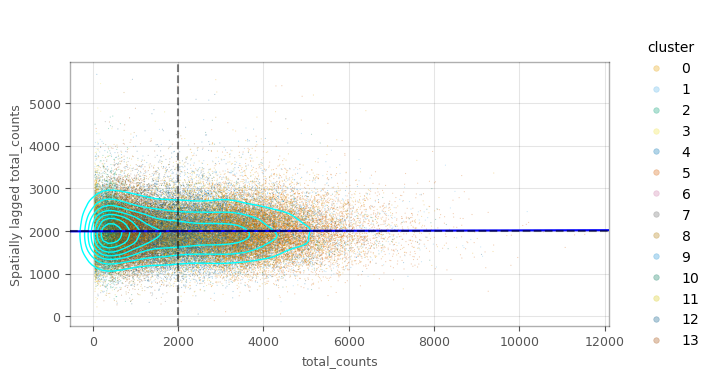

In [91]:
ax = vp.plt.moran_plot(andata_sub, feature="total_counts", color_by='cluster', alpha=0.3,s = 0.1)

In [93]:
_ = vp.spatial.local_moran(andata_sub, qc_features, graph_name=knn_graph)

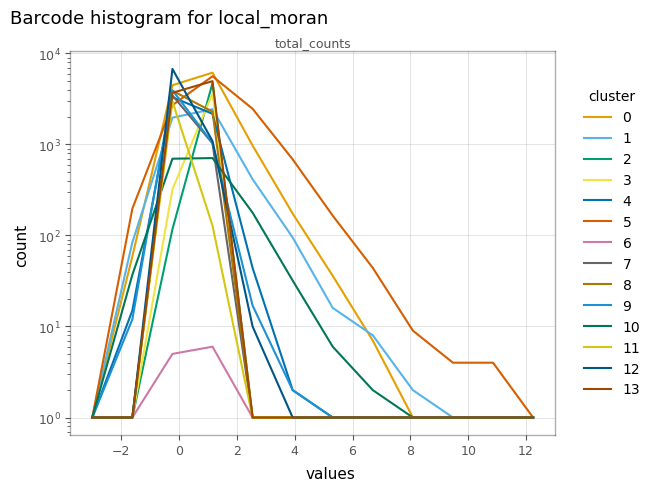

In [94]:
axs = vp.plt.plot_barcode_histogram(
    andata_sub,
    qc_features,
    obsm="local_moran",
    color_by='cluster',
    log=True,
    histtype='line',
    bins=10,
)

In [ ]:
hvg = andata_sub.var[andata_sub.var['highly_variable'].values].index
vp.spatial.moran(andata_sub, feature=hvg, dim='var', graph_name=knn_graph)

In [92]:
andata_sub.var.loc[:, ["moran"]] = np.nan_to_num(andata_sub.var.loc[:, ["moran"]],0.0)
andata_sub.var.loc[hvg, ["moran"]].sort_values(by='moran')

KeyError: "None of [Index(['moran'], dtype='object')] are in the [columns]"

In [ ]:
_ = vp.spatial.local_moran(andata_sub, qc_features, graph_name=knn_graph)

In [ ]:
axs = vp.plt.plot_barcode_histogram(
    andata_sub,
    qc_features,
    obsm="local_moran",
    color_by='cluster',
    log=True,
    histtype='line',
    bins=10,
)

In [ ]:
hvg = andata_sub.var[andata_sub.var['highly_variable'].values].index

In [ ]:
vp.spatial.moran(andata_sub, feature=hvg, dim='var', graph_name=knn_graph)

In [ ]:
hvgs_moransI = andata_sub.uns['spatial']['moran'][knn_graph].loc[hvg, 'I']
andata_sub.var.loc[hvg, "moran"] = hvgs_moransI

In [ ]:
andata_sub.var.loc[hvg, ["moran"]].sort_values(by='moran')

In [ ]:
andata_sub.var.loc[:, ["moran"]] = np.nan_to_num(andata_sub.var.loc[:, ["moran"]],0.0)
andata_sub.var.loc[hvg, ["moran"]].sort_values(by='moran')